# Tutorial 4: Build Protein-Ligand MDFPs from MD Simulations

## Outline 

0. Useful Information before starting <br>


1. MD Simulations and Post-Processing <br>
    1.1 Recompute protein-ligand energy terms <br>
    1.2 Compute single residue-ligand energy terms <br>
    1.3 Recentering Coordinates <br>
    1.4 Test case <br>
    

2. Construct Protein-Ligand MDFPs for a single replica  <br>
    
    
3. Construct Protein-Ligand MDFPs from a multiple replica <br>



## 0. Useful Information before starting 

#### I)   INPUT FILES:
MD trajectory (.xtc, .h5, .trr), coordinates file (.gro or .pdb), and file containing energy terms extracted from the trajectories (.xvg or .csv).

#### II) REQUIRED SOFTWARES AND PYTHON LIBRARIES

##### Softwares:
python3 <br>

##### Python Liraries:
RDKit <br>
subprocess<br>
pandas <br>
numpy <br>
glob <br>
mdtraj <br>
pymol <br>
os <br>
scipy <br>


## 1 MD Simulations and Post-Processing

MD Simulations of protein-ligand complexes can be run with different simulation software and using different set ups.
In this tutorial, we will not focus on how to set up MD simulations but on how to extract features from them and construct a MDFP. Multiple functions have been included in the MDFPTools package to calculate energy terms, the ligand solvent accessible surface area (SASA), the ligand radius of gyration (Rgyr), and the root-mean-square deviation (RMSD) of the ligand from the starting conformation. 

For a single protein-ligand complex, a single or multiple replicas can be run, for example starting from different docked poses. When multiple replicas are available for the same system, one can consider different approaches to construct the MDFPs:
* Average the features over each of the replicas and include each term in the descriptor. 
    This implies that there will be N entries for each feature, where N is the number of replicas. For example, for simulations run in 3 replicas you will have Rgyr_av_1, Rgyr_av_2, Rgyr_av_3.
* Average the features over all replicas.
* Average the feautures only over the replica exhibiting the lowest average total potential energy.

Features are stored in the MDFP as mean (<i>_av</i>), standard deviation (<i>_std</i>), and median (<i>_med</i>).

Functions are available for each of these scenarios and in this tutorial we will guide you through the MDFP construction step by step.

### 1.1 Recompute protein-ligand energy terms
Most often, in MD simulations the long-range electrostatic interactions are dealt with using Particle-Mesh Ewald (PME). PME is not pairwise additive. Therefore, to be able to decompose the energy into contributions from the different parts of the system (protein, ligand, and water), it is essential to recompute the energy terms using reaction-field (RF), which instead is pairwise additive. 

To recompute the energy terms from GROMACS simulations, you can use the _-rerun_ option of _mdrun_ (See also the [GROMACS documentation](http://manual.gromacs.org/documentation/5.1/user-guide/mdrun-features.html)).
First, you should generate a copy of the _mdp_ file used to carry out the simulations, e.g _md_RF.mdp_.
Then, you should modify  _md_RF.mdp_ as follows:
* replace the PME options with the RF options
* specify the energy groups you are interested in:

    energygrps = LIG Protein Water      #assuming that the ligand molecule is named "LIG"
    energygrp-excl   = Protein Protein  #exclude protein-protein interactions. 

Recompute the energy terms by running the following commands: 

    gmx_mpi grompp -f md_RF.mdp -c system.gro -p system.top -o md_RF.tpr
    gmx_mpi mdrun -s md_RF.tpr -rerun md.xtc -e md_RF.edr



The output file _md_RF.edr_ will contain the energy terms recomputed with RF.
Now you can extract the energy terms you are interested in using the _gmx energy_ function. For example:

    gmx_mpi energy -f md_RF.edr -o md_RF.xvg <<EOF
    Coul-SR:Water-LIG
    LJ-SR:Water-LIG
    Coul-14:Water-LIG
    LJ-14:Water-LIG
    Coul-SR:LIG-LIG
    LJ-SR:LIG-LIG
    Coul-14:LIG-LIG
    LJ-14:LIG-LIG
    Coul-SR:LIG-Protein
    LJ-SR:LIG-Protein
    Coul-14:LIG-Protein
    LJ-14:LIG-Protein

    EOF

This command assumes that the ligand molecule is named LIG.
The energy terms include the intramolecular potential energy of the solute (LIG-LIG), the solute-protein interaction energy (LIG-Protein), the solute-water interaction energy (Water-LIG), and the total potential energy (intramolecular + solute-protein + solute-water). These energy contributions are further split into Lennard Jones (LJ) and electrostatic components (Coul).  




### 1.2 Compute single residue-ligand energy terms
To compute single residue-ligand energy terms, you can use again the _-rerun_ option of _mdrun_.
Once more, you need to recompute the energy terms using RF instead of PME. The same _md_RF.mdp_ file as the one described above can be used. However, this time you need to specify as energy groups the molecular name of the ligand (LIG) and the residue you are interested in:

    energygrps = LIG r_RESIDUE
    
where RESIDUE is the residue number. For example:

    energygrps = LIG r_255
    
To exclude the residue-residue interactions, which are not interesting, and the LIG-LIG interaction which you have already computed in the previous step, update the following line in the _mdp_ file:

    energygrp-excl   = r_RESIDUE r_RESIDUE LIG LIG  

Before computing the energy terms, you need to generate the index groups for the residues of interest. This can be done using the _gmx make_ndx_ function of GROMACS (See also the [GROMACS documentation](http://manual.gromacs.org/documentation/2018/onlinehelp/gmx-make_ndx.html)). For example, to generate the index groups for residues 145, 180, and 225: 

    gmx_mpi make_ndx -f system.gro -o index_system.ndx <<EOF
    ri 145
    ri 180
    ri 255
    q
    EOF
    
Finally, as described above, recompute the energy terms as follows:

    gmx_mpi grompp -f md_RF_residue.mdp -c system.gro -p system.top -o md_RF_residue.tpr -n index_system.ndx
    gmx_mpi mdrun -s md_RF_residue.tpr -rerun md.xtc -e md_RF_residue.edr
    gmx_mpi energy -f md_RF_residue.edr -o ene_res_255.xvg <<EOF
    LJ-SR:LIG-r_255
    Coul-SR:LIG-r_255
    
    EOF

These steps have to be repeated for each of the residues of interest.
The following paragraphs explain how to contruct the protein-ligand MDFPs from trajectory and energy (_xvg_) files. 

### 1.3 Recentering Coordinates

Different tools are available for centering the system in the box and align the system to a reference structure, e.g. GROMACS, VMD, MDTraj.

The GROMACS commands are the followings:

To center the system in the box:

    gmx trjconv -f md.xtc -s md.tpr -n index_system.ndx -pbc mol -ur compact -center -o center_md.xtc 

To remove center-of-mass motion and rotation from a trajectory:

    gmx trjconv -s md.tpr -f center_md.xtc -o center_fit_md.xtc -fit rot+trans
    
(Choose "Backbone" to perform least-squares fitting to the protein backbone, and "System" for output.)
    
See also the [GROMACS tutorial](http://www.mdtutorials.com/gmx/complex/09_analysis.html) provided by the Lemkul Lab ([Ref](https://www.livecomsjournal.org/article/5068-from-proteins-to-perturbed-hamiltonians-a-suite-of-tutorials-for-the-gromacs-2018-molecular-simulation-package-article-v1-0)).


### 1.4 Test Case

In the `ex4_PL_MDFPs` folder we provide test energy files and trajectories for two protein-ligand complexes. The files were generated in the context of a project aimed at predicting P-glycoprotein substrates.
To decrease the computational cost of the simulations, the system was simplified by truncating the cytosolic and extracellular domains and by using an implicit solvent to mimic the membrane environment. Explicit water molecule were, however, added to the binding cavity. Stochastic dynamics simulations were carried out at 300 K for 6 ns. Simulations were carried out in 5 replicas. 

## 2 Construct Protein-Ligand MDFPs for a single replica 

Import required libraries

In [1]:
from Extractor_PLMDFP import *
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

Read required input files: trajectory file (.xtc), coordinates file (.gro), and file containing energy terms (.xvg, see above)

In [2]:
cmpd_name = 'CHEMBL7568'
traj_file = 'ex4_PL_MDFPs/nvt1_frict4_complex_{}_pH7_netcharge_out1.xtc'.format(cmpd_name)
energy_file = 'ex4_PL_MDFPs/nvt_frict4_ana_complex_{}_pH7_netcharge_out1.xvg'.format(cmpd_name)
coord_file = 'ex4_PL_MDFPs/{}_pH7_netcharge.gro'.format(cmpd_name)

Read in energy terms and plot the time series:

In [3]:
df_ene = Extractor_PLMDFP.read_xvg(energy_file)
df_ene.head()

,time,Coul-SR:Water-LIG,LJ-SR:Water-LIG,Coul-14:Water-LIG,LJ-14:Water-LIG,Coul-SR:LIG-LIG,LJ-SR:LIG-LIG,Coul-14:LIG-LIG,LJ-14:LIG-LIG,Coul-SR:LIG-Protein,LJ-SR:LIG-Protein,Coul-14:LIG-Protein,LJ-14:LIG-Protein
0,0.0,2.007488,-1.597029,0.0,0.0,-45.567692,-6.299019,72.543045,66.968025,35.632534,-167.007355,0.0,0.0
1,2.0,-61.078720,-0.331545,0.0,0.0,-74.069496,-24.153023,79.346390,56.661655,-120.960983,-152.872711,0.0,0.0
2,4.0,-64.242950,-8.786523,0.0,0.0,-139.760529,-30.034159,75.236519,64.062714,-87.207458,-155.718079,0.0,0.0
3,6.0,-98.186920,-10.033812,0.0,0.0,-111.678307,-28.897713,81.030273,60.565495,-117.857925,-170.329117,0.0,0.0
4,8.0,-83.169022,-11.254222,0.0,0.0,-120.779465,-33.488495,78.480255,54.064140,-107.085869,-167.329681,0.0,0.0


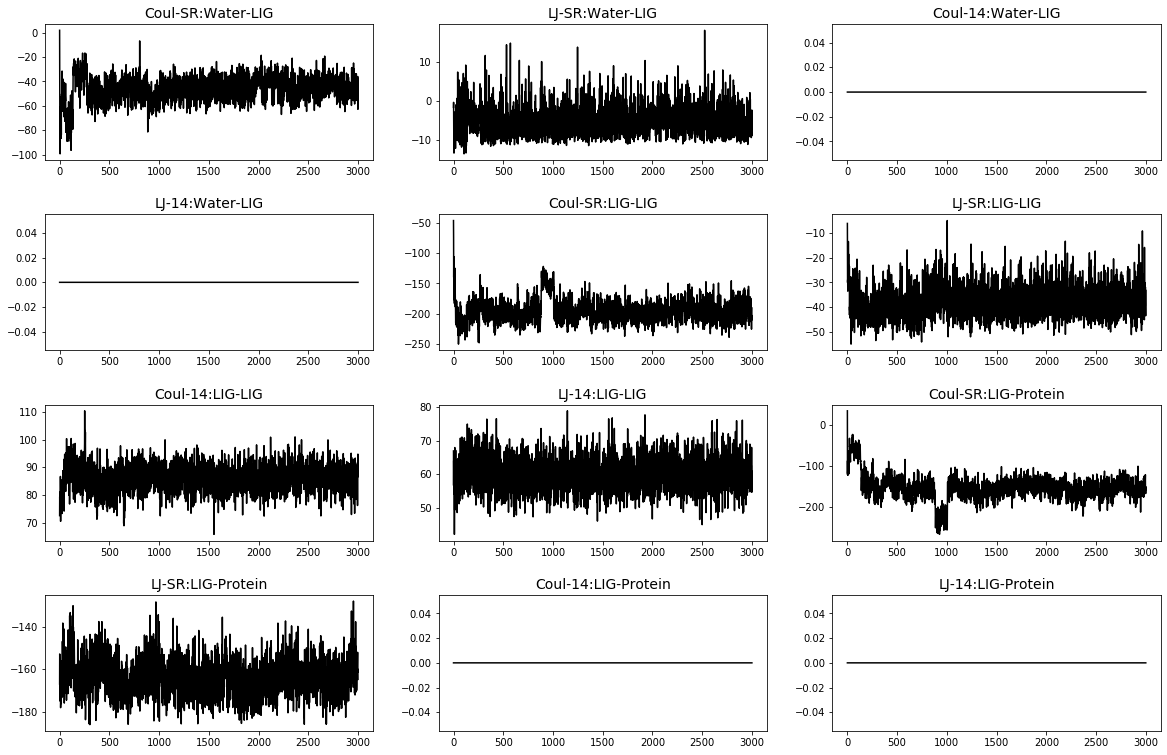

In [4]:
fig, axes = plt.subplots(4,3, figsize=(20,13))
for col1 in range(1, len(list(df_ene.columns))):
    i = int(np.floor((col1-1)/3))
    j = int((col1-1) - i*3)
    axes[i,j].plot(df_ene[df_ene.columns[col1]], color = 'black')
    axes[i,j].set_title(df_ene.columns[col1], fontsize = 14)
    
plt.subplots_adjust(hspace = 0.4)


Exclude from the MDFP construction the initial 500 steps (1 ns) for equlibration:

In [5]:
N_equil_steps = 500

Initialize output dictionary in which to store MDFP terms

In [6]:
Fingerprint = [] # initialize list of dictionaries. one for each compound
Dict_Fingerprint = {} # initialize dictionary

Add name of the compound to the dictionary

In [7]:
Dict_Fingerprint.update({'cmpd_name': cmpd_name})

Calculate Protein-Ligand energy terms:

In [8]:
ene_prot_lig = Extractor_PLMDFP.extract_protein_ligang_energy_terms_single(xvg_file = energy_file, \
                                                                           N_equil = N_equil_steps, \
                                                                           solute_name = "LIG")
Dict_Fingerprint.update(ene_prot_lig)
pd.DataFrame([Dict_Fingerprint])

,cmpd_name,intra_crf_pl_av,intra_crf_pl_std,intra_crf_pl_med,intra_lig_lj_pl_av,intra_lig_lj_pl_std,intra_lig_lj_pl_med,intra_ene_pl_av,intra_ene_pl_std,intra_ene_pl_med,...,tot_ene_pl_med,wat_lig_crf_pl_av,wat_lig_crf_pl_std,wat_lig_crf_pl_med,wat_lig_lj_pl_av,wat_lig_lj_pl_std,wat_lig_lj_pl_med,wat_lig_ene_pl_av,wat_lig_ene_pl_std,wat_lig_ene_pl_med
0,CHEMBL7568,-108.811495,17.394809,-111.28405,22.328899,8.653008,21.722645,-86.482595,19.230652,-88.879646,...,-460.337352,-45.051827,8.24203,-44.492081,-5.489435,3.511677,-6.122062,-50.541262,8.311696,-50.129177


Extract residue-ligand energy terms for three residues, res180, res145, and res255.
If in the file name, the residue number is preceeded by the string "res_", then the function is able to guess the residue number, which is returned in the dictionary. Otherwise the residue number can be provided as input to the function (see help(Extractor_PLMDFP.extract_residue_ligand_energy_terms)).
If the residue number cannot be guessed and is not provided as input, then the xvg file name is returned in the output dictionary.

In [9]:
xvg_files_res_lig = glob.glob('ex4_PL_MDFPs/ene_res*{}*out1.xvg'.format(cmpd_name))
xvg_files_res_lig


['ex4_PL_MDFPs/ene_res_180_lig_complex_CHEMBL7568_pH7_netcharge_out1.xvg',
 'ex4_PL_MDFPs/ene_res_145_lig_complex_CHEMBL7568_pH7_netcharge_out1.xvg',
 'ex4_PL_MDFPs/ene_res_255_lig_complex_CHEMBL7568_pH7_netcharge_out1.xvg']

In [10]:
for f1 in xvg_files_res_lig:
    dict_ene_res_lig = Extractor_PLMDFP.extract_residue_ligand_energy_terms(xvg_file = f1, N_equil = N_equil_steps)
    Dict_Fingerprint.update(dict_ene_res_lig)
    


Check for example the energy terms computed for the last residue. You can see that the residue number was correctly guessed from the xvg file name.

In [11]:
print(dict_ene_res_lig)

{'res255_crf_pl_av': -3.181179011995202, 'res255_crf_pl_std': 1.0433673463655366, 'res255_crf_pl_med': -3.1696400000000002, 'res255_lj_pl_av': -0.8180936093562574, 'res255_lj_pl_std': 0.13346867640601784, 'res255_lj_pl_med': -0.803507, 'res255_ene_pl_av': -3.9992726213514596, 'res255_ene_pl_std': 1.0685353518253782, 'res255_ene_pl_med': -3.9680400000000002}


Calculate other proprieties (SASA, Rgyr, and RMSD) from the trajectory. The following commands assume that the system in the trajectory has been already recentered and aligned (see section 1.3):

In [12]:
# The following steps are required to read in the trajectory and compute SASA, Rgyr, and RMSD (only std):
# conver gro to pdb
Extractor_PLMDFP.gro2pdb(coord_file)
# the output pdb file will have the same name of the gro file
pdb_file = os.path.splitext(coord_file)[0] + '.pdb'
# load pdb and identify indices of solute atoms
pdb = md.load(pdb_file)
topology = pdb.topology
solute_atoms = Extractor_PLMDFP.solute_solvent_split(topology, solute_residue_name='LIG')[0]
# read in the trajectory but only for the solute. Protein and water molecules not loaded
solute_traj = md.load(traj_file, top=pdb_file, atom_indices = solute_atoms)



In [13]:
# Compute SASA, Rgyr, and RMSD and add the terms to the output dictionary
Dict_Fingerprint.update(Extractor_PLMDFP.extract_rgyr(solute_traj, N_equil = N_equil_steps))
Dict_Fingerprint.update(Extractor_PLMDFP.extract_sasa(solute_traj, N_equil = N_equil_steps))
Dict_Fingerprint.update(Extractor_PLMDFP.extract_rmsd(solute_traj, N_equil = N_equil_steps))
pd.DataFrame([Dict_Fingerprint])

,cmpd_name,intra_crf_pl_av,intra_crf_pl_std,intra_crf_pl_med,intra_lig_lj_pl_av,intra_lig_lj_pl_std,intra_lig_lj_pl_med,intra_ene_pl_av,intra_ene_pl_std,intra_ene_pl_med,...,res255_ene_pl_av,res255_ene_pl_std,res255_ene_pl_med,rgyr_pl_av,rgyr_pl_std,rgyr_pl_med,sasa_pl_av,sasa_pl_std,sasa_pl_med,rmsd_pl_std
0,CHEMBL7568,-108.811495,17.394809,-111.28405,22.328899,8.653008,21.722645,-86.482595,19.230652,-88.879646,...,-3.999273,1.068535,-3.96804,0.428532,0.007532,0.428072,7.016097,0.120784,7.010949,0.014159


Append dictionary containing all the extracted terms to a list and convert the list to a data frame. 

In [14]:
Fingerprint.append(Dict_Fingerprint)
pd.DataFrame(Fingerprint)

,cmpd_name,intra_crf_pl_av,intra_crf_pl_std,intra_crf_pl_med,intra_lig_lj_pl_av,intra_lig_lj_pl_std,intra_lig_lj_pl_med,intra_ene_pl_av,intra_ene_pl_std,intra_ene_pl_med,...,res255_ene_pl_av,res255_ene_pl_std,res255_ene_pl_med,rgyr_pl_av,rgyr_pl_std,rgyr_pl_med,sasa_pl_av,sasa_pl_std,sasa_pl_med,rmsd_pl_std
0,CHEMBL7568,-108.811495,17.394809,-111.28405,22.328899,8.653008,21.722645,-86.482595,19.230652,-88.879646,...,-3.999273,1.068535,-3.96804,0.428532,0.007532,0.428072,7.016097,0.120784,7.010949,0.014159


This is useful if you want to loop over multiple compounds. To do that, the loop should look like this:

In [15]:
N_equil_steps = 500
list_cmpd_names = ['CHEMBL7568','CHEMBL605310']
Fingerprint = [] # initialize list of dictionaries. one for each compound
for cmpd_name in list_cmpd_names:
    traj_file = 'ex4_PL_MDFPs/nvt1_frict4_complex_{}_pH7_netcharge_out1.xtc'.format(cmpd_name)
    energy_file = 'ex4_PL_MDFPs/nvt_frict4_ana_complex_{}_pH7_netcharge_out1.xvg'.format(cmpd_name)
    coord_file = 'ex4_PL_MDFPs/{}_pH7_netcharge.gro'.format(cmpd_name)    
    Dict_Fingerprint = {} # initialize dictionary
    Dict_Fingerprint.update({'cmpd_name': cmpd_name})
    Dict_Fingerprint.update(Extractor_PLMDFP.extract_protein_ligang_energy_terms_single(xvg_file = energy_file, N_equil = N_equil_steps, solute_name = "LIG"))
    xvg_files_res_lig = glob.glob('ex4_PL_MDFPs/ene_res*{}*out1.xvg'.format(cmpd_name))
    for f1 in xvg_files_res_lig:
        Dict_Fingerprint.update(Extractor_PLMDFP.extract_residue_ligand_energy_terms(xvg_file = f1, N_equil = N_equil_steps))
    # read in the trajectory and compute additional properties using MDTraj functions
    Extractor_PLMDFP.gro2pdb(coord_file)
    pdb_file = os.path.splitext(coord_file)[0] + '.pdb'
    pdb = md.load(pdb_file)
    topology = pdb.topology
    solute_atoms = Extractor_PLMDFP.solute_solvent_split(topology, solute_residue_name='LIG')[0]
    solute_traj = md.load(traj_file, top=pdb_file, atom_indices = solute_atoms)
    Dict_Fingerprint.update(Extractor_PLMDFP.extract_rgyr(solute_traj, N_equil = N_equil_steps))
    Dict_Fingerprint.update(Extractor_PLMDFP.extract_sasa(solute_traj, N_equil = N_equil_steps))
    Dict_Fingerprint.update(Extractor_PLMDFP.extract_rmsd(solute_traj, N_equil = N_equil_steps))
    Fingerprint.append(Dict_Fingerprint)


In [16]:
pd.DataFrame(Fingerprint)

,cmpd_name,intra_crf_pl_av,intra_crf_pl_std,intra_crf_pl_med,intra_lig_lj_pl_av,intra_lig_lj_pl_std,intra_lig_lj_pl_med,intra_ene_pl_av,intra_ene_pl_std,intra_ene_pl_med,...,res255_ene_pl_av,res255_ene_pl_std,res255_ene_pl_med,rgyr_pl_av,rgyr_pl_std,rgyr_pl_med,sasa_pl_av,sasa_pl_std,sasa_pl_med,rmsd_pl_std
0,CHEMBL7568,-108.811495,17.394809,-111.284050,22.328899,8.653008,21.722645,-86.482595,19.230652,-88.879646,...,-3.999273,1.068535,-3.968040,0.428532,0.007532,0.428072,7.016097,0.120784,7.010949,0.014159
1,CHEMBL605310,11.594098,13.021279,14.215638,59.054797,10.191339,58.667179,70.648895,15.602179,72.010250,...,-6.039279,1.474989,-6.080509,0.405889,0.006746,0.405408,7.564301,0.122572,7.558150,0.025953


#### To Customize MDFPs at your own will, see also section 2 of Tutorial 2 "Customize MDFPs"

## 3 Construct Protein-Ligand MDFPs from Multiple Replicas

To enhance sampling, trajectories are often run in multiple replicas. For example, for protein-ligand complexes for which the crystal structure is not available, multiple simulations can be strarted from different docking poses. As described above, in such senario, there are different possible ways to average the features extracted from the trajectories to compose the MDFPs:

* Average the features over each of the replicas and include each term in the descriptor. 
* Average the features over all replicas.
* Average the feautures only over the replica exhibiting the lowest average total potential energy.

For the first approach, the functions described in the previous section can be used.
Below, we are going to show the use of functions that follow the second and third approaches.



First, let's compare the energy contributions computed from five different replicas

In [17]:
cmpd_name = 'CHEMBL7568'
energy_files = glob.glob('ex4_PL_MDFPs/nvt_frict4_ana_complex_{}_pH7_netcharge_out*.xvg'.format(cmpd_name))
energy_files

    

['ex4_PL_MDFPs/nvt_frict4_ana_complex_CHEMBL7568_pH7_netcharge_out1.xvg',
 'ex4_PL_MDFPs/nvt_frict4_ana_complex_CHEMBL7568_pH7_netcharge_out2.xvg',
 'ex4_PL_MDFPs/nvt_frict4_ana_complex_CHEMBL7568_pH7_netcharge_out3.xvg',
 'ex4_PL_MDFPs/nvt_frict4_ana_complex_CHEMBL7568_pH7_netcharge_out4.xvg',
 'ex4_PL_MDFPs/nvt_frict4_ana_complex_CHEMBL7568_pH7_netcharge_out5.xvg']

In [18]:
# read in energy files 
list_df_ene = []
for ene1 in energy_files:
    list_df_ene.append(Extractor_PLMDFP.read_xvg(ene1))
    

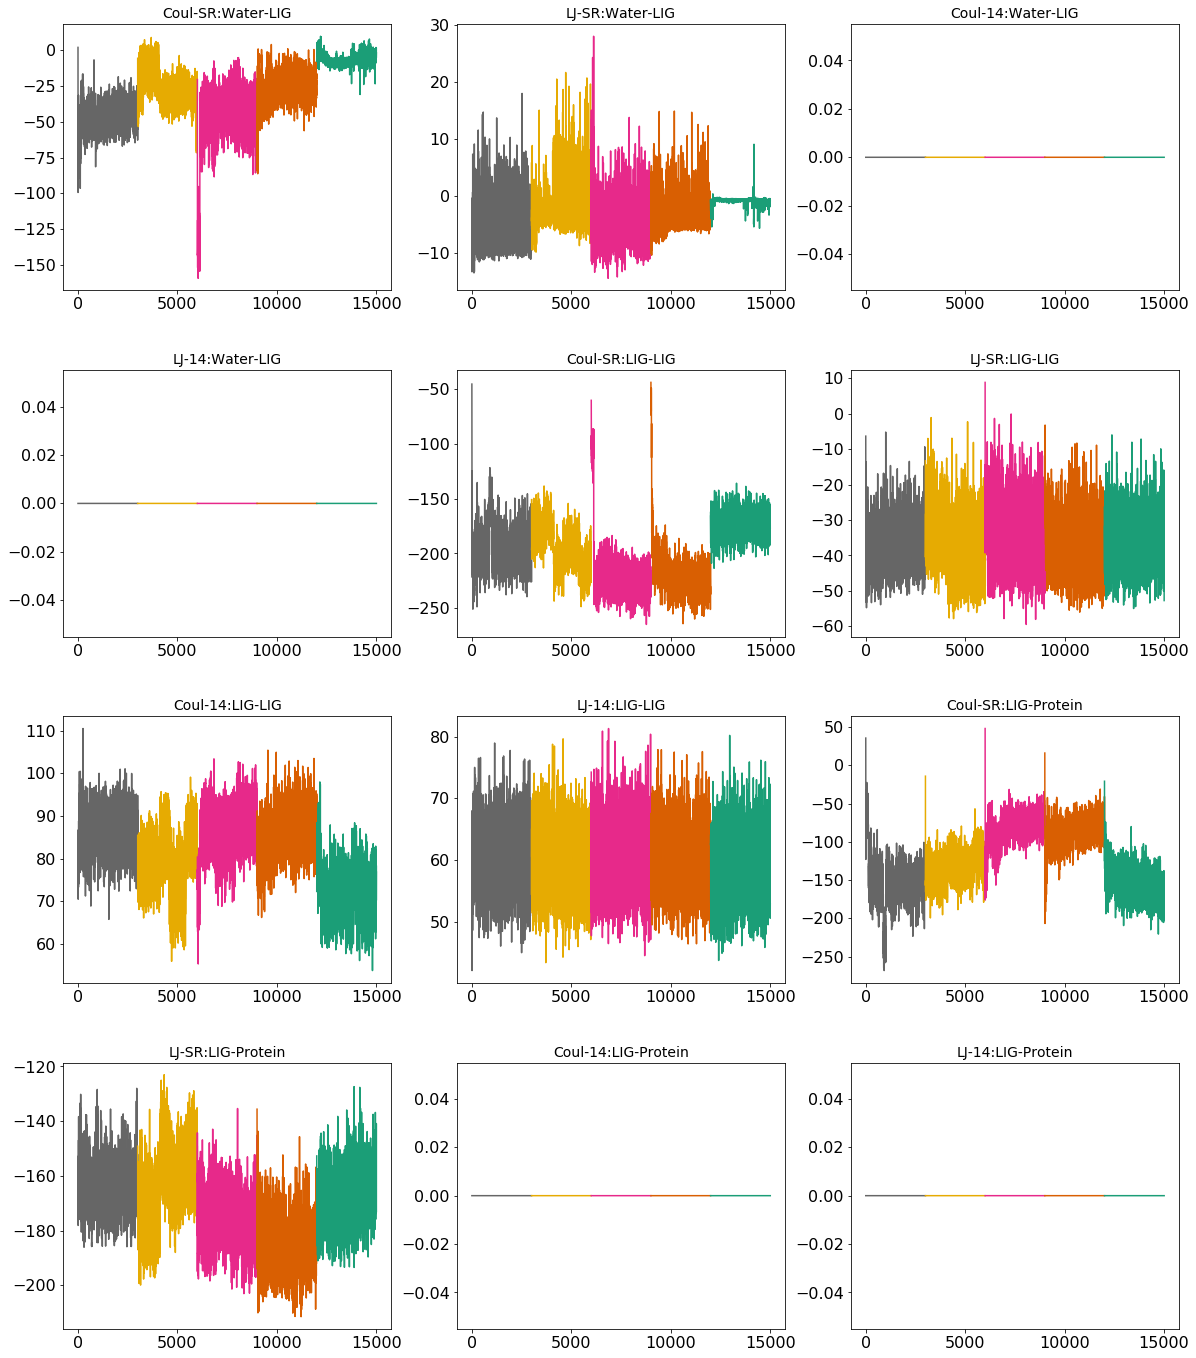

In [19]:
# plot time series for each of the replicas:
# Different replicas are shown in differnt colors.

fig, axes = plt.subplots(4, 3, figsize=(20, 24))
N_replicas = len(energy_files)
colors = plt.cm.Dark2_r(np.linspace(0,1,N_replicas))

for rep1 in range(N_replicas):
    df2 = list_df_ene[rep1]
    for col1 in range(1, len(list(df2.columns))):
        i = int(np.floor((col1-1)/3))
        j = int((col1-1) - i*3)
        x_axis = list(range(0 + len(list(df2.index))*rep1, len(list(df2.index))*(rep1+1)))
        axes[i, j].plot(x_axis, df2[df2.columns[col1]], color = colors[rep1])
        #axes[i, j].set_title(df2.columns[col1],fontsize=20)
        axes[i, j].set_ylabel("", fontsize=16)
        if i != 4:
            axes[i, j].set_xlabel("", fontsize=16)
        else:
            axes[i, j].set_xlabel("replicas", fontsize=20)
        axes[i,j].set_title(df2.columns[col1], fontsize = 14)
        plt.setp(axes[i, j].get_xticklabels(), rotation=0, fontsize = 16)
        plt.setp(axes[i, j].get_yticklabels(), rotation=0, fontsize = 16)
        axes[i, j].tick_params(labelsize = 16)

plt.subplots_adjust(hspace = 0.3) 

Different replicas have different energy profiles. This may result from the ligand exploring different binding modes. Again, one could consider the replica with the minimum total energy as the most likely and average the features over that replica only. Or one may consider all binding modes as probable and average the features over all replicas.

### Initialize output variables

In [20]:
Fingerprint = [] # initialize list of dictionaries. one for each compound
Dict_Fingerprint = {} # initialize dictionary

Add name of the compound to the dictionary

In [21]:
Dict_Fingerprint.update({'cmpd_name': cmpd_name})

### Compute protein-ligand energy terms

For each of the energy terms composing the MDFP, compute the mean, standard deviation, and median over all replicas (<i>_all\_replicas</i>) and over the replica with the lowest average total potential energy (<i>_min_replica</i>). Return also the name of the replica with the lowest total energy. 

In [22]:
N_equil_steps = 500 # as done in the previous section

ene_prot_lig, min_pose = Extractor_PLMDFP.extract_min_and_mean_protein_ligang_energy(energy_files, \
                                                                                     N_equil = N_equil_steps, \
                                                                                     return_min_filename = True)
Dict_Fingerprint.update(ene_prot_lig)

In [23]:
pd.DataFrame([ene_prot_lig])

,intra_crf_pl_av_all_replicas,intra_crf_pl_std_all_replicas,intra_crf_pl_med_all_replicas,intra_lig_lj_pl_av_all_replicas,intra_lig_lj_pl_std_all_replicas,intra_lig_lj_pl_med_all_replicas,intra_ene_pl_av_all_replicas,intra_ene_pl_std_all_replicas,intra_ene_pl_med_all_replicas,prot_lig_crf_pl_av_all_replicas,...,tot_ene_pl_med_min_replica,wat_lig_crf_pl_av_min_replica,wat_lig_crf_pl_std_min_replica,wat_lig_crf_pl_med_min_replica,wat_lig_lj_pl_av_min_replica,wat_lig_lj_pl_std_min_replica,wat_lig_lj_pl_med_min_replica,wat_lig_ene_pl_av_min_replica,wat_lig_ene_pl_std_min_replica,wat_lig_ene_pl_med_min_replica
0,-120.410567,19.75553,-122.479698,22.160995,9.388944,21.568603,-98.249572,21.223545,-100.651154,-122.094259,...,-460.337352,-45.051827,8.24203,-44.492081,-5.489435,3.511677,-6.122062,-50.541262,8.311696,-50.129177


The replica with the minimum total energy is: 

In [24]:
min_pose

'ex4_PL_MDFPs/nvt_frict4_ana_complex_CHEMBL7568_pH7_netcharge_out1.xvg'

### Compute residue-ligand energy terms



In [25]:
xvg_files_res_lig = glob.glob('ex4_PL_MDFPs/ene_res*{}*out*.xvg'.format(cmpd_name))
residues_list = [180, 145, 255]

In [26]:
ene_res_lig = Extractor_PLMDFP.extract_residue_ligand_energy_terms_multi_supplier(xvg_files_res_lig, \
                                                                                  list_residue_numbers = residues_list, \
                                                                                  N_equil = N_equil_steps)
pd.DataFrame([ene_res_lig])

,res180_crf_pl_av_0,res180_crf_pl_std_0,res180_crf_pl_med_0,res180_lj_pl_av_0,res180_lj_pl_std_0,res180_lj_pl_med_0,res180_ene_pl_av_0,res180_ene_pl_std_0,res180_ene_pl_med_0,res180_crf_pl_av_1,...,res255_ene_pl_med_4,res255_crf_pl_av_all_replicas,res255_crf_pl_std_all_replicas,res255_crf_pl_med_all_replicas,res255_lj_pl_av_all_replicas,res255_lj_pl_std_all_replicas,res255_lj_pl_med_all_replicas,res255_ene_pl_av_all_replicas,res255_ene_pl_std_all_replicas,res255_ene_pl_med_all_replicas
0,-0.770735,0.433269,-0.728534,-0.546204,0.137922,-0.531431,-1.316938,0.493706,-1.255295,0.144033,...,-0.335978,-0.351077,1.683153,0.189792,-0.310871,0.269436,-0.196048,-0.661948,1.911654,0.027672


The function above returns the averages over each replica and the averages over all replicas. 
To construct the MDFP, only the averages over all replicas are required. Therefore, only the features labelled as <i>"_all_replicas"</i> are added to the output dictionary (Dict_Fingerprint)

In [27]:
ene_res_lig2 = {k: ene_res_lig[k] for k in ene_res_lig.keys() if 'all_replicas' in k}
Dict_Fingerprint.update(ene_res_lig2)

Average the residue-ligand energy terms only over the replica with the minimum total potential energy:

In [28]:
ene_res_lig_min = {k: ene_res_lig[k] for k in ene_res_lig.keys() if '_1' in k}
ene_res_lig_min = {k.replace('_1','')+'_min_replica': v for k, v in ene_res_lig_min.items()}

or, alternatively:

In [29]:
min_pose_number = os.path.basename(min_pose).split(".")[0].split("_")[-1] # this depends on the xvg file names.
xvg_files_res_lig_min = [x for x in xvg_files_res_lig if min_pose_number in x]
xvg_files_res_lig_min

['ex4_PL_MDFPs/ene_res_145_lig_complex_CHEMBL7568_pH7_netcharge_out1.xvg',
 'ex4_PL_MDFPs/ene_res_180_lig_complex_CHEMBL7568_pH7_netcharge_out1.xvg',
 'ex4_PL_MDFPs/ene_res_255_lig_complex_CHEMBL7568_pH7_netcharge_out1.xvg']

In [30]:
ene_res_lig_min = Extractor_PLMDFP.extract_residue_ligand_energy_terms_multi_supplier(xvg_files_res_lig_min, \
                                                                                      list_residue_numbers = residues_list, \
                                                                                      N_equil = N_equil_steps)
ene_res_lig_min = {k+'_min_replica': v for k, v in ene_res_lig_min.items()}

In [31]:
pd.DataFrame([ene_res_lig_min])

,res180_crf_pl_av_min_replica,res180_crf_pl_std_min_replica,res180_crf_pl_med_min_replica,res180_lj_pl_av_min_replica,res180_lj_pl_std_min_replica,res180_lj_pl_med_min_replica,res180_ene_pl_av_min_replica,res180_ene_pl_std_min_replica,res180_ene_pl_med_min_replica,res145_crf_pl_av_min_replica,...,res145_ene_pl_med_min_replica,res255_crf_pl_av_min_replica,res255_crf_pl_std_min_replica,res255_crf_pl_med_min_replica,res255_lj_pl_av_min_replica,res255_lj_pl_std_min_replica,res255_lj_pl_med_min_replica,res255_ene_pl_av_min_replica,res255_ene_pl_std_min_replica,res255_ene_pl_med_min_replica
0,-0.770735,0.433269,-0.728534,-0.546204,0.137922,-0.531431,-1.316938,0.493706,-1.255295,4.679821,...,-3.120721,-3.181179,1.043367,-3.16964,-0.818094,0.133469,-0.803507,-3.999273,1.068535,-3.96804


Append results to the output dictionary:

In [32]:
Dict_Fingerprint.update(ene_res_lig_min)

### Compute SASA, Rgyr, and RMSD

Only the standard deviation of the RMSD is computed as mean and median depend on the reference structure.

In [33]:
list_traj_files = glob.glob('ex4_PL_MDFPs/*{}_*.xtc'.format(cmpd_name))

In [34]:
# load solute trajectories. This is done as in the previous section but trajectory objects are stored in a list:
Extractor_PLMDFP.gro2pdb(coord_file)
pdb_file = os.path.splitext(coord_file)[0] + '.pdb'
pdb = md.load(pdb_file)
topology = pdb.topology
solute_atoms = Extractor_PLMDFP.solute_solvent_split(topology, solute_residue_name='LIG')[0]
solute_trj_objs = []
for traj_file in list_traj_files:
    solute_trj_objs.append(md.load(traj_file, top=pdb_file, atom_indices = solute_atoms))
    
# averages over all replicas
rgyr = Extractor_PLMDFP.extract_rgyr_multi(solute_trj_objs, N_equil = N_equil_steps)
sasa = Extractor_PLMDFP.extract_sasa_multi(solute_trj_objs, N_equil = N_equil_steps)
rmsd = Extractor_PLMDFP.extract_rmsd_multi(solute_trj_objs, N_equil = N_equil_steps)
Dict_Fingerprint.update({k: rgyr[k] for k in rgyr.keys() if 'all_replicas' in k}) 
Dict_Fingerprint.update({k: sasa[k] for k in sasa.keys() if 'all_replicas' in k}) 
Dict_Fingerprint.update({k: rmsd[k] for k in rmsd.keys() if 'all_replicas' in k}) 
###### averages over minimum replica
solute_traj_min_file = glob.glob('ex4_PL_MDFPs/*{}_*{}.xtc'.format(cmpd_name, min_pose_number))[0] # this depends on the xtc file names.
solute_traj_min = md.load(solute_traj_min_file, top=pdb_file, atom_indices = solute_atoms)
rgyr_min = Extractor_PLMDFP.extract_rgyr(solute_traj_min, N_equil = N_equil_steps)
sasa_min = Extractor_PLMDFP.extract_sasa(solute_traj_min, N_equil = N_equil_steps)
rmsd_min = Extractor_PLMDFP.extract_rmsd(solute_traj_min, N_equil = N_equil_steps)
Dict_Fingerprint.update({k+'_min_replica': v for k, v in rgyr_min.items()})
Dict_Fingerprint.update({k+'_min_replica': v for k, v in sasa_min.items()})
Dict_Fingerprint.update({k+'_min_replica': v for k, v in rmsd_min.items()})
Fingerprint.append(Dict_Fingerprint)


As described above in section 2, one can easily loop over multiple compounds. For each compound, one should store the output dictionary (Dict_Fingerprint) in the output list (Fingerprint).

In [35]:
df_MDFP = pd.DataFrame(Fingerprint)
df_MDFP

,cmpd_name,intra_crf_pl_av_all_replicas,intra_crf_pl_std_all_replicas,intra_crf_pl_med_all_replicas,intra_lig_lj_pl_av_all_replicas,intra_lig_lj_pl_std_all_replicas,intra_lig_lj_pl_med_all_replicas,intra_ene_pl_av_all_replicas,intra_ene_pl_std_all_replicas,intra_ene_pl_med_all_replicas,...,sasa_pl_std_all_replicas,sasa_pl_med_all_replicas,rmsd_pl_std_all_replicas,rgyr_pl_av_min_replica,rgyr_pl_std_min_replica,rgyr_pl_med_min_replica,sasa_pl_av_min_replica,sasa_pl_std_min_replica,sasa_pl_med_min_replica,rmsd_pl_std_min_replica
0,CHEMBL7568,-120.410567,19.75553,-122.479698,22.160995,9.388944,21.568603,-98.249572,21.223545,-100.651154,...,0.118452,7.50807,0.016541,0.406349,0.006309,0.405968,7.509152,0.112582,7.502111,0.01303


### MDFP built with features averaged over all replicas

In [36]:
df_MDFP.loc[:, df_MDFP.columns.str.endswith('all_replicas')]

,intra_crf_pl_av_all_replicas,intra_crf_pl_std_all_replicas,intra_crf_pl_med_all_replicas,intra_lig_lj_pl_av_all_replicas,intra_lig_lj_pl_std_all_replicas,intra_lig_lj_pl_med_all_replicas,intra_ene_pl_av_all_replicas,intra_ene_pl_std_all_replicas,intra_ene_pl_med_all_replicas,prot_lig_crf_pl_av_all_replicas,...,res255_ene_pl_av_all_replicas,res255_ene_pl_std_all_replicas,res255_ene_pl_med_all_replicas,rgyr_pl_av_all_replicas,rgyr_pl_std_all_replicas,rgyr_pl_med_all_replicas,sasa_pl_av_all_replicas,sasa_pl_std_all_replicas,sasa_pl_med_all_replicas,rmsd_pl_std_all_replicas
0,-120.410567,19.75553,-122.479698,22.160995,9.388944,21.568603,-98.249572,21.223545,-100.651154,-122.094259,...,-0.661948,1.911654,0.027672,0.406085,0.0064,0.405756,7.513907,0.118452,7.50807,0.016541


### MDFP built with features averaged over the replica with the minimum total potential energy**

In [37]:
df_MDFP.loc[:, df_MDFP.columns.str.endswith('min_replica')]

,intra_crf_pl_av_min_replica,intra_crf_pl_std_min_replica,intra_crf_pl_med_min_replica,intra_lig_lj_pl_av_min_replica,intra_lig_lj_pl_std_min_replica,intra_lig_lj_pl_med_min_replica,intra_ene_pl_av_min_replica,intra_ene_pl_std_min_replica,intra_ene_pl_med_min_replica,prot_lig_crf_pl_av_min_replica,...,res255_ene_pl_av_min_replica,res255_ene_pl_std_min_replica,res255_ene_pl_med_min_replica,rgyr_pl_av_min_replica,rgyr_pl_std_min_replica,rgyr_pl_med_min_replica,sasa_pl_av_min_replica,sasa_pl_std_min_replica,sasa_pl_med_min_replica,rmsd_pl_std_min_replica
0,-108.811495,17.394809,-111.28405,22.328899,8.653008,21.722645,-86.482595,19.230652,-88.879646,-159.09552,...,-3.999273,1.068535,-3.96804,0.406349,0.006309,0.405968,7.509152,0.112582,7.502111,0.01303
